In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import os

#### Fixed variables

In [140]:
# store map size (pixels)
STORE_SIZE = [3136, 2475] 
# camera origin point in store map
CAMERA_ORIGIN_POINT = {"1.03": (1079, 1219), "1.04": (1103, 1420), "1.05": (1124, 1417), "2.05": (998, 1663), "2.11": (1175, 769)} 
# dimensoes da imagem apenas com a projeção dos pontos de cada camara
CAMERA_PROJECTION_SIZE = (456, 342)

SAVE_IMG_PATH = '/Users/chainz/Desktop/Tese/Dados/Projeções/mapa_modificado_1camera.png'


#### Read camera data

In [141]:
def read_camera_data(camera):
    files = os.path.join("/Users/chainz/Desktop/Tese/Dados/Trajetorias/14.03.2022/" + str(camera), "*.csv")
    files = glob.glob(files)
    data_from_camera = []
    for filename in files:
        df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
        df["camera"] = camera
        data_from_camera.append(df)
    return pd.concat(data_from_camera, axis=0, ignore_index=True)

#### Read and concatenate data from all cameras

In [142]:
def concatenate_data_all_cameras():
    dir_list = os.listdir("/Users/chainz/Desktop/Tese/Dados/Trajetorias/14.03.2022/")
    remove_words = ["teste", ".ipynb_checkpoints", ".DS_Store"]
    camera_list = list(filter(lambda directory: directory not in remove_words, dir_list))

    data_all_cameras = []
    for camera in camera_list:
        files = os.path.join("/Users/chainz/Desktop/Tese/Dados/Trajetorias/14.03.2022/" + str(camera), "*.csv")
        files = glob.glob(files)
        for filename in files:
            df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
            df["camera"] = camera
            data_all_cameras.append(df)

    return pd.concat(data_all_cameras, axis=0, ignore_index=True)


#### Transformations

In [143]:
def get_min_and_max_values_per_camera(camera_data):
    min_x = min(camera_data["x_floorplan"])
    min_y = min(camera_data["y_floorplan"])
    max_x = max(camera_data["x_floorplan"])
    max_y = max(camera_data["y_floorplan"])
    return min_x, min_y, max_x, max_y

def get_scale_multiplier(min, max, camera_projection_size):
    return camera_projection_size / (max - min)

In [144]:
def transform_coordinates(df):
    for camera in df["camera"].unique():
        #camera_data = df[df["camera"] == camera]
        origin_x, origin_y = CAMERA_ORIGIN_POINT[camera]
        min_x, min_y, max_x, max_y = get_min_and_max_values_per_camera(df[df["camera"] == camera])
        scale_multiplier_x = get_scale_multiplier(min_x, max_x, CAMERA_PROJECTION_SIZE[0])
        scale_multiplier_y = get_scale_multiplier(min_x, max_x, CAMERA_PROJECTION_SIZE[1])
        df.loc[df.camera == camera, 'x_floorplan'] = df['x_floorplan'].map(lambda x: ((x + abs(min_x)) * scale_multiplier_x) + origin_x)
        df.loc[df.camera == camera, 'y_floorplan'] = df['y_floorplan'].map(lambda y: ((y + abs(min_y)) * scale_multiplier_y) + origin_y)
    return df

def print_trajectory(df):
    img = plt.imread("/Users/chainz/Desktop/Tese/Dados/mapa original.png")
    fig, ax = plt.subplots()
    fig.set_dpi(1200)
    ax.imshow(img, extent=[0, STORE_SIZE[0], 0, STORE_SIZE[1]])
    plt.scatter(df["x_floorplan"], df["y_floorplan"], marker=".", s=1, lw=0, color="blue")
    plt.savefig(SAVE_IMG_PATH, dpi=1200)


#### Main

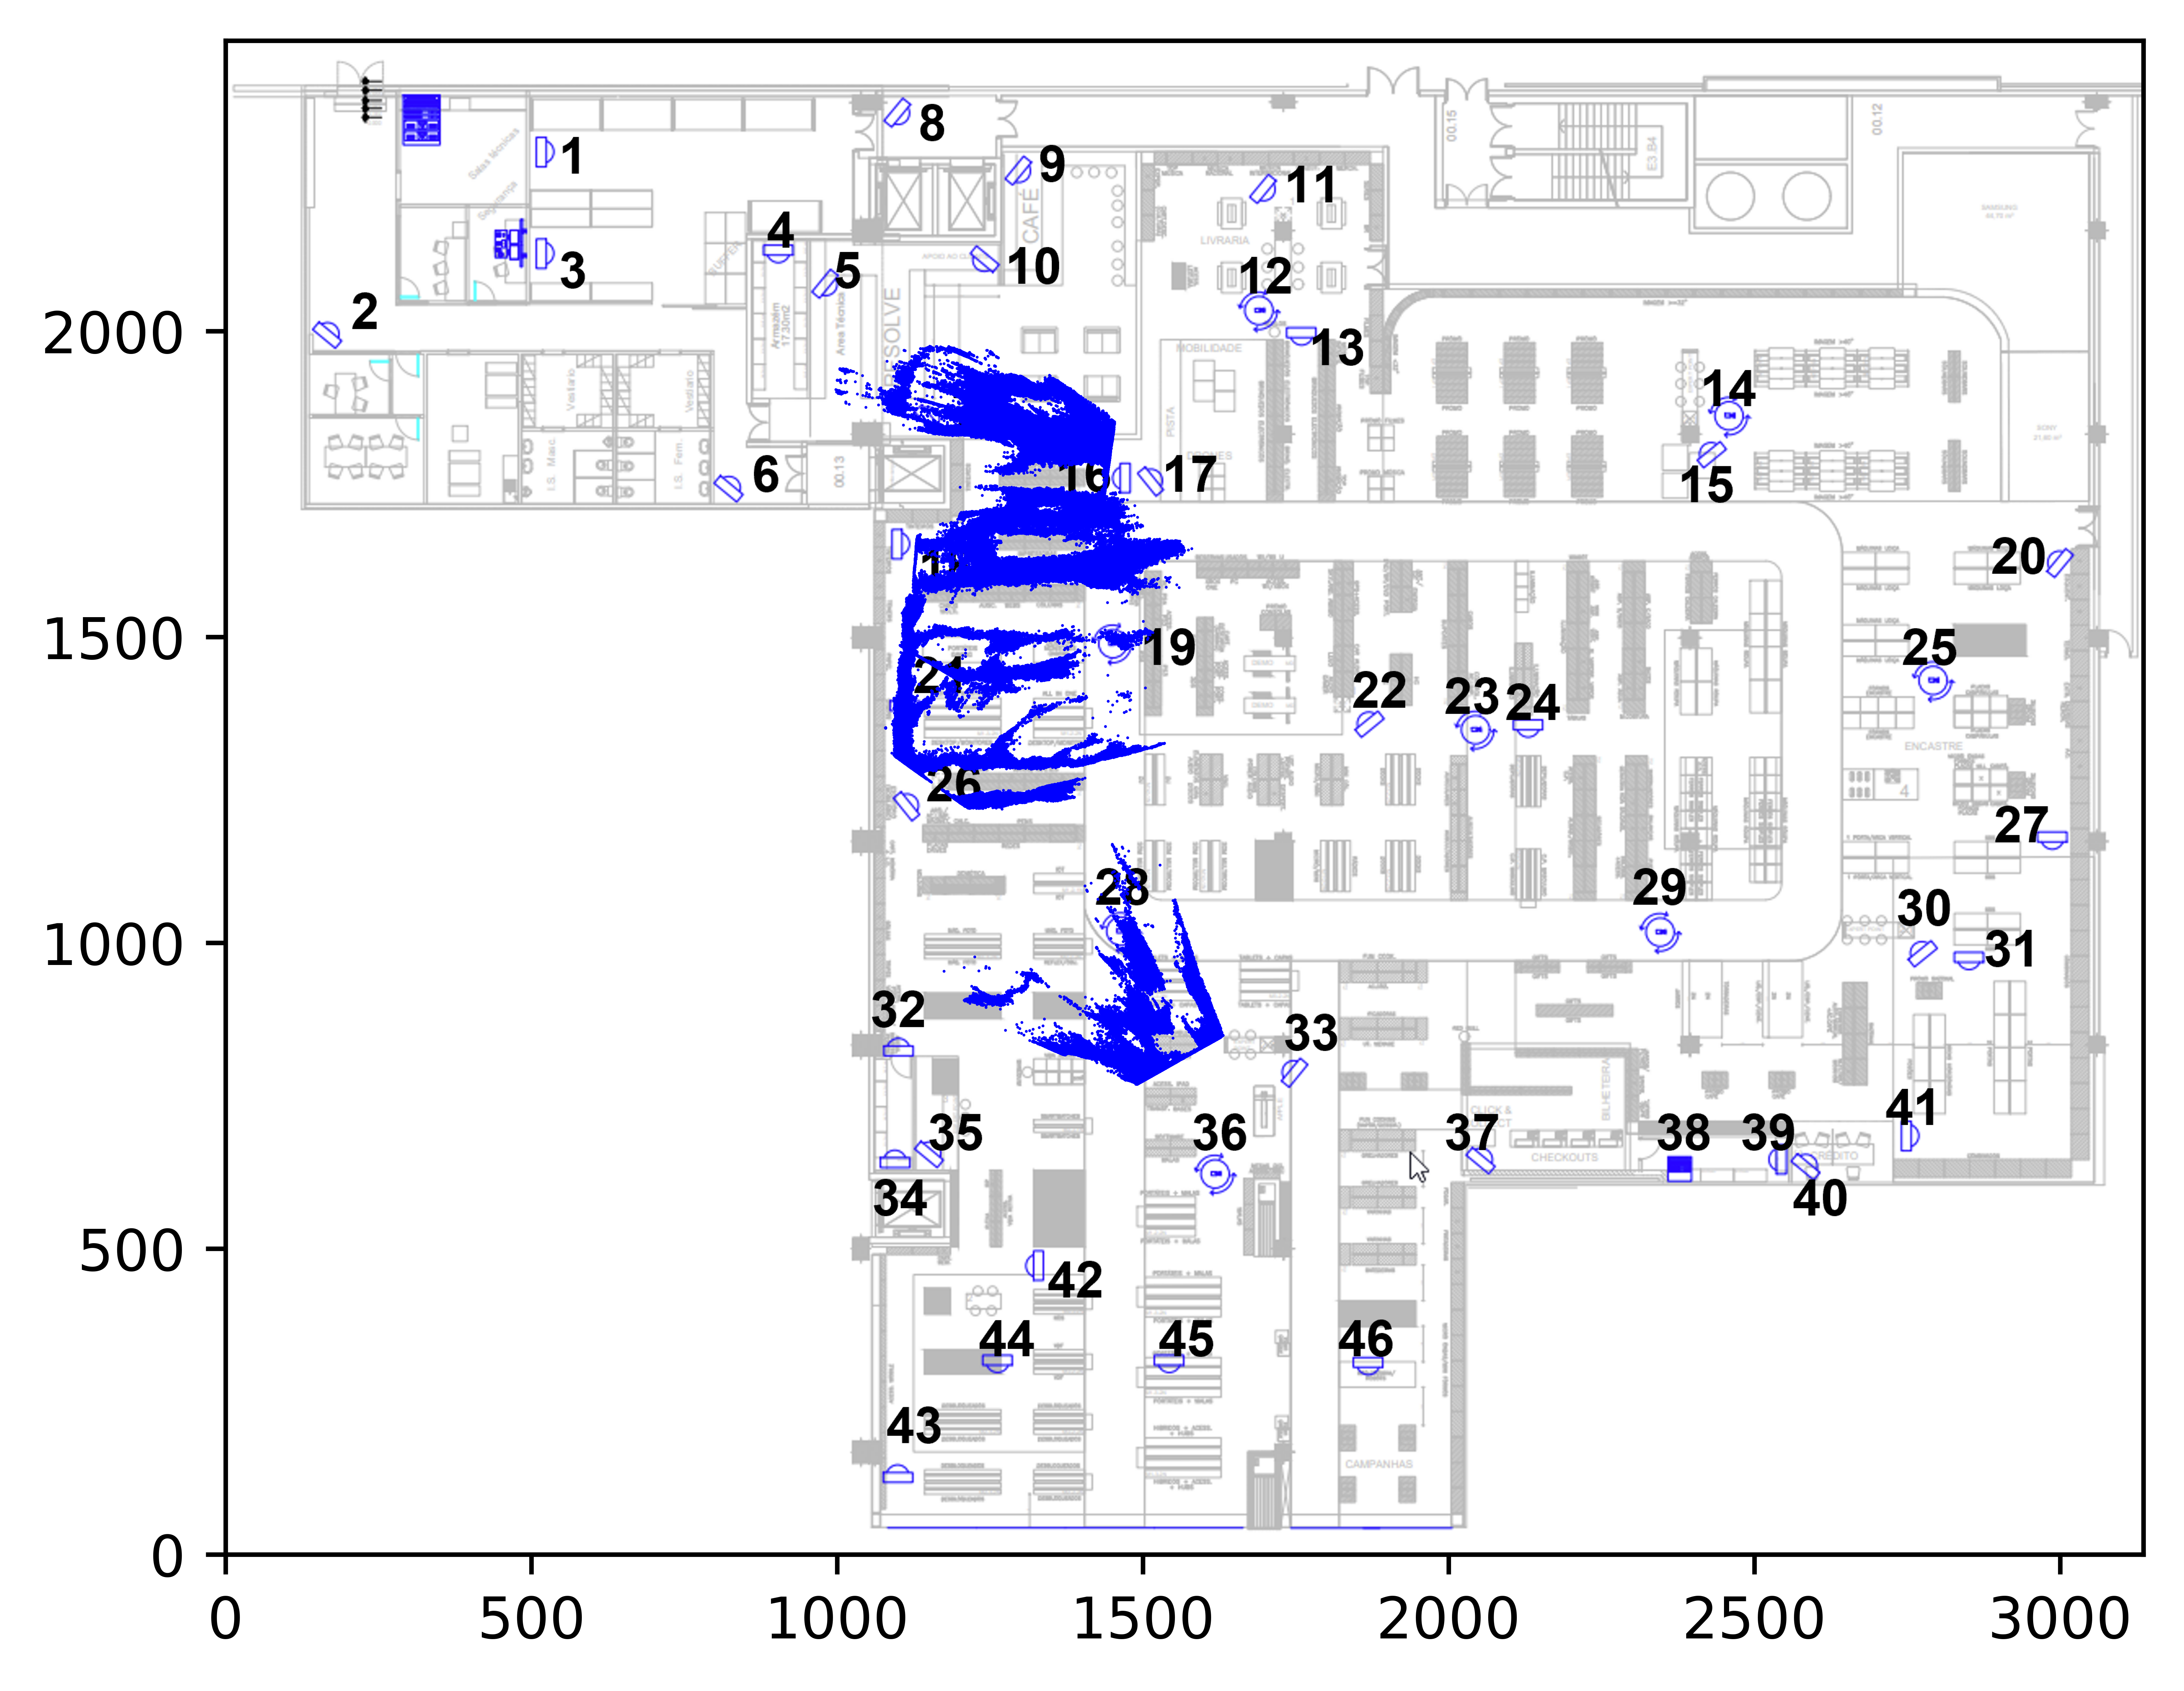

In [145]:
all_data = concatenate_data_all_cameras()
new_data = transform_coordinates(all_data)
new_data.head()
print_trajectory(new_data)

# NOTAS: A camera 2.11 não tem dados muito fiáveis e encontra-se longe das restantes camaras